In [1]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

/home/griffing52/miniconda3/envs/seg/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Download model

In [3]:
model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"
processor = SegformerImageProcessor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)

/home/griffing52/miniconda3/envs/seg/lib/python3.13/site-packages/transformers/image_processing_base.py:370: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Loading weights: 100%|██████████| 208/208 [00:00<00:00, 3262.41it/s, Materializing param=segformer.encoder.patch_embeddings.3.proj.weight]            


## Inference on single image!

In [4]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTL0o6GE2daUNcY6klb5kboC3FMcWzTw8aq4w&s"
image = Image.open(requests.get(url, stream=True).raw)

In [5]:
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    # The output logit size is usually 1/4th of the input size, so we upsample
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1], # (height, width)
        mode="bilinear",
        align_corners=False,
    )
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

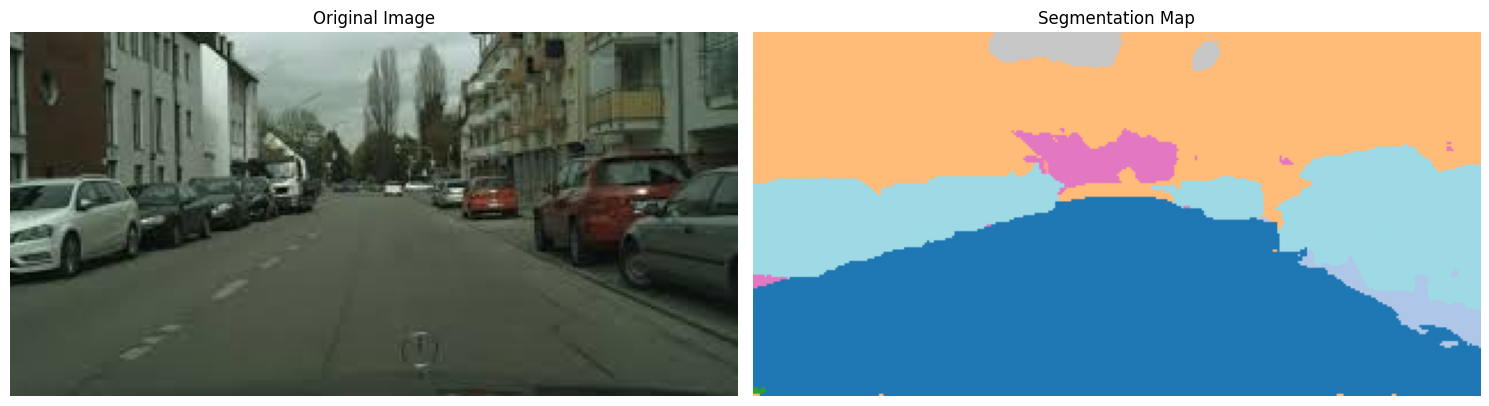

In [6]:
def visualize_segmentation(original_image, segmentation_map):
    plt.figure(figsize=(15, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Plot Segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map, cmap='tab20') # 'tab20' gives distinct colors
    plt.title("Segmentation Map")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_segmentation(image, pred_seg)

In [7]:
!pip install cityscapesscripts

  Using cached pyquaternion-0.9.9-py3-none-any.whl.metadata (1.4 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Using cached pyquaternion-0.9.9-py3-none-any.whl (14 kB)
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26399 sha256=c0befa77e6ae5401f8203b8c84edbec2908daf683b5681aff11715e3e3e03abb
  Stored in directory: /home/griffing52/.cache/pip/wheels/5d/1b/f4/fbdc2bc618f0ba7aec7295d67f62d40e6027a6ce14df9ec3c8
Successfully built typing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [cityscapesscripts]


In [8]:
# --- Step 1: SegFormer + Cityscapes label schema and per-image prediction ---

from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict

import numpy as np
from PIL import Image
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Cityscapes label definitions (gives id, trainId, category, etc.)
# pip install cityscapesscripts if you don't have it yet
from cityscapesscripts.helpers.labels import labels as CS_LABELS

# -------- Label configuration (generic pattern for any dataset) --------

@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    ignore_in_eval: bool # True for '+' labels / void classes


def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    """
    Build LabelSpec objects directly from Cityscapes metadata.
    """
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,                         # flat, human, vehicle, ...
            id=lab.id,
            train_id=lab.trainId,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs


CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Group -> list of class names (for inspection / grouping)
CITYSCAPES_GROUPS: Dict[str, List[str]] = defaultdict(list)
for spec in CITYSCAPES_LABEL_SPECS.values():
    CITYSCAPES_GROUPS[spec.group].append(spec.name)

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes: trainId >= 0 and not ignoreInEval
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

# We keep 0..255 as possible trainIds (255 = void)
CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255


def segformer_predict_cityscapes_trainids(image: Image.Image) -> np.ndarray:
    """
    Segment an image with SegFormer.

    Returns:
        pred_trainids: (H, W) uint8 array of Cityscapes trainIds
                       (0-18 for eval classes, 255 = void/ignore)
    """
    # Ensure RGB
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Upsample logits to original image size (H, W)
        # image.size is (W, H)
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

    # argmax gives the class index (trainId for this model)
    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)

    return pred_seg

In [ ]:
# If your dataset is on Drive, mount and point ROOT there
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
from pathlib import Path
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/cityscapes")
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")
CITYSCAPES_ROOT = Path("../data/cityscapes")

In [11]:
# --- Step 2: Load Cityscapes val split paths in Colab ---

def list_cityscapes_split(root: Path, split: str = "val"):
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    image_paths = sorted(img_dir.rglob("*_leftImg8bit.png"))
    print(f"Found {len(image_paths)} images in split='{split}'")
    return image_paths, gt_dir

val_image_paths, val_gt_dir = list_cityscapes_split(CITYSCAPES_ROOT, split="val")


Found 500 images in split='val'


In [17]:
# --- Step 3: Build a parseable representation (DataFrame) for val ---

import pandas as pd

def make_cityscapes_dataframe(root: Path, split: str = "val") -> pd.DataFrame:
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    records = []
    for img_path in sorted(img_dir.rglob("*_leftImg8bit.png")):
        city = img_path.parent.name
        stem = img_path.name.replace("_leftImg8bit.png", "")

        label_ids = gt_dir / city / f"{stem}_gtFine_labelIds.png"
        instance_ids = gt_dir / city / f"{stem}_gtFine_instanceIds.png"
        color_png = gt_dir / city / f"{stem}_gtFine_color.png"
        polygons_json = gt_dir / city / f"{stem}_gtFine_polygons.json"

        records.append(
            {
                "city": city,
                "image_id": stem,
                "image_path": str(img_path),
                "labelIds_path": str(label_ids),
                "instanceIds_path": str(instance_ids),
                "color_path": str(color_png),
                "polygons_path": str(polygons_json),
            }
        )

    df = pd.DataFrame.from_records(records)
    return df


val_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="val")
print("Total val samples:", len(val_df))
display(val_df.head())


Total val samples: 500


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path
0,frankfurt,frankfurt_000000_000294,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...
1,frankfurt,frankfurt_000000_000576,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...
2,frankfurt,frankfurt_000000_001016,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...
3,frankfurt,frankfurt_000000_001236,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...
4,frankfurt,frankfurt_000000_001751,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...


In [16]:
# --- Step 4: Run SegFormer inference over every row in the DataFrame ---

from tqdm.auto import tqdm
import numpy as np

PRED_ROOT = CITYSCAPES_ROOT / "segformer_preds" / "val"
PRED_ROOT.mkdir(parents=True, exist_ok=True)


def run_segformer_inference_over_df(
    df: pd.DataFrame,
    pred_root: Path,
    overwrite: bool = False,
) -> pd.DataFrame:
    """
    Generic pattern:
      - iterate df rows
      - load image
      - call a `predict(image)` function (here: segformer_predict_cityscapes_trainids)
      - save predictions to disk
      - store prediction path back into df
    """
    df = df.copy()
    pred_paths = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(row["image_path"])
        image_id = row["image_id"]

        out_path = pred_root / f"{image_id}_segformer_trainIds.npy"
        if out_path.exists() and not overwrite:
            pred_paths.append(str(out_path))
            continue

        img = Image.open(img_path).convert("RGB")
        pred_trainids = segformer_predict_cityscapes_trainids(img)

        np.save(out_path, pred_trainids)
        pred_paths.append(str(out_path))

    df["pred_trainIds_path"] = pred_paths
    return df


val_df_pred = run_segformer_inference_over_df(
    val_df,
    pred_root=PRED_ROOT,
    overwrite=False,
)

display(val_df_pred.head())

100%|██████████| 500/500 [00:40<00:00, 12.42it/s]


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path,pred_trainIds_path
0,frankfurt,frankfurt_000000_000294,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/segformer_preds/val/frankfu...
1,frankfurt,frankfurt_000000_000576,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/segformer_preds/val/frankfu...
2,frankfurt,frankfurt_000000_001016,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/segformer_preds/val/frankfu...
3,frankfurt,frankfurt_000000_001236,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/segformer_preds/val/frankfu...
4,frankfurt,frankfurt_000000_001751,../data/cityscapes/leftImg8bit_trainvaltest/le...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/gtFine_trainvaltest/gtFine/...,../data/cityscapes/segformer_preds/val/frankfu...


In [18]:
import numpy as np
# --- Step 5: Evaluate SegFormer predictions (semantic mIoU) ---

def labelIds_to_trainIds(label_ids: np.ndarray) -> np.ndarray:
    """
    Map Cityscapes labelIds to trainIds using CITYSCAPES_ID2TRAINID.
    255 is used as ignore index.
    """
    train = np.full_like(label_ids, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
    for raw_id, tid in CITYSCAPES_ID2TRAINID.items():
        train[label_ids == raw_id] = np.uint8(tid)
    return train


def confusion_matrix_from_df(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for _, row in df.iterrows():
        gt = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
        gt_train = labelIds_to_trainIds(gt)

        pred_train = np.load(row["pred_trainIds_path"]).astype(np.int32)
        assert gt_train.shape == pred_train.shape, "GT/pred shape mismatch"

        # Ignore pixels where GT is void
        mask = gt_train != ignore_index
        gt_flat = gt_train[mask]
        pred_flat = pred_train[mask]

        # Clamp predictions to valid range [0, num_classes-1]
        pred_flat = np.clip(pred_flat, 0, num_classes - 1)

        # Explicitly cast to int64 to prevent OverflowError with bincount
        indices = (np.int64(num_classes) * gt_flat + pred_flat).astype(np.int64)

        cm += np.bincount(
            indices,
            minlength=num_classes ** 2,
        ).reshape(num_classes, num_classes)

    return cm


def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(1) + cm.sum(0) - intersection
    iou = intersection / np.maximum(union, 1)
    return iou


cm = confusion_matrix_from_df(val_df_pred)
ious = iou_from_confusion(cm)

print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

Per-class IoU (Cityscapes 19 eval classes):
 0         road: 97.83%
 1     sidewalk: 83.22%
 2     building: 90.38%
 3         wall: 51.08%
 4        fence: 51.84%
 5         pole: 51.49%
 6 traffic light: 61.06%
 7 traffic sign: 71.66%
 8   vegetation: 91.11%
 9      terrain: 64.22%
10          sky: 94.23%
11       person: 70.26%
12        rider: 37.35%
13          car: 92.81%
14        truck: 77.36%
15          bus: 79.79%
16        train: 65.48%
17   motorcycle: 47.29%
18      bicycle: 69.62%

Mean IoU over 19 classes: 70.95%


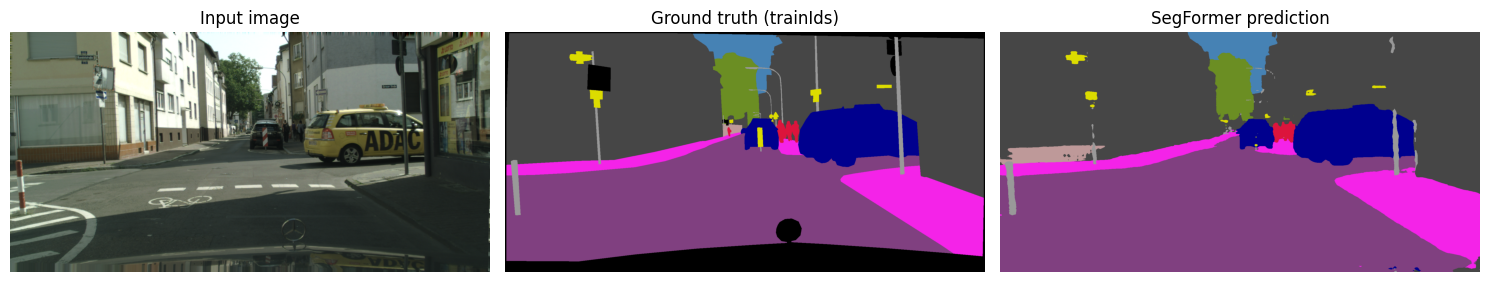

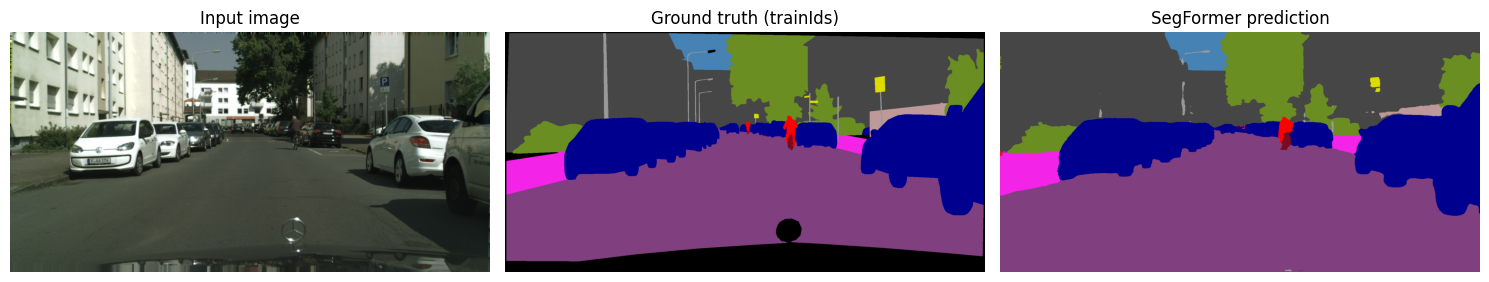

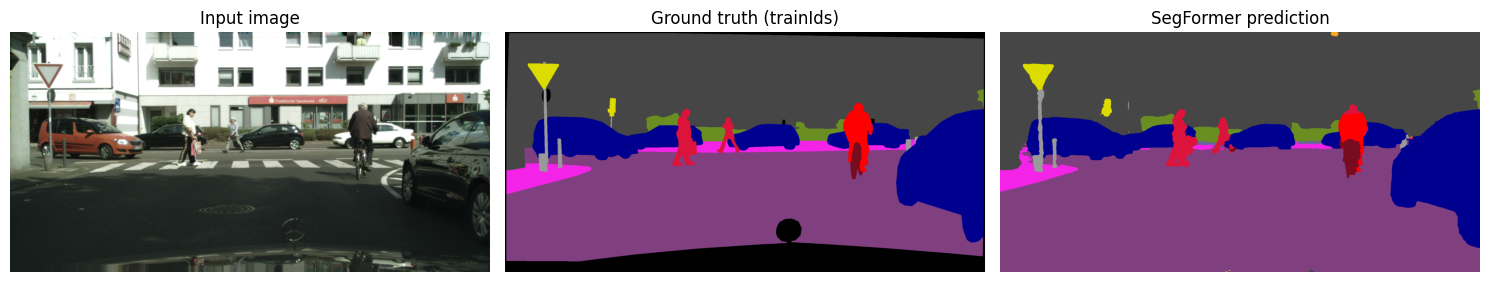

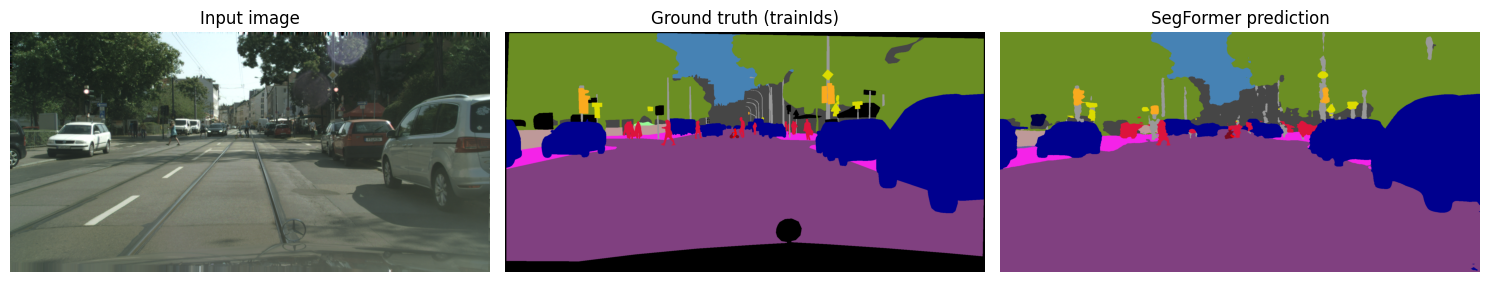

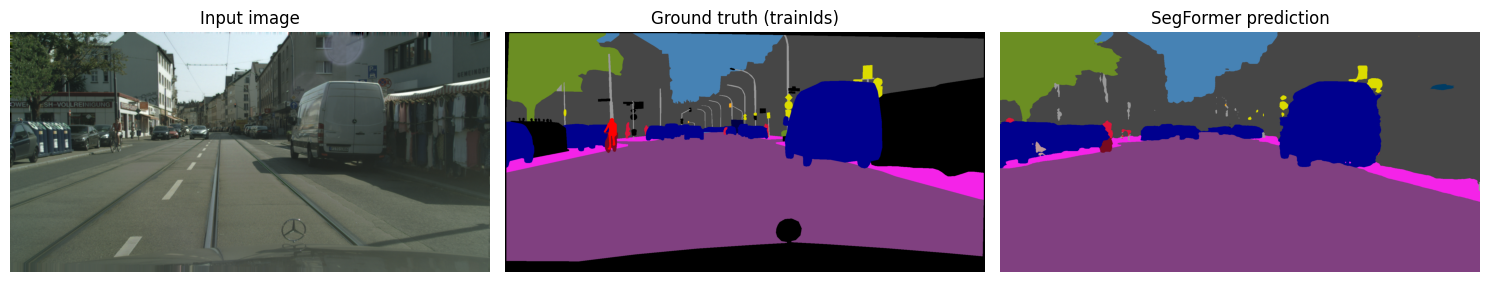

In [19]:
# --- Visualize first few SegFormer inference results (image | GT | prediction) ---

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from cityscapesscripts.helpers import labels as cs_labels  # already imported as CS_LABELS earlier

# Build a color palette for trainIds using official Cityscapes colors
TRAINID2COLOR = {}
for lab in cs_labels.labels:
    if lab.trainId < 0 or lab.trainId == 255:  # ignore / void
        continue
    TRAINID2COLOR[lab.trainId] = lab.color  # (R, G, B)

def colorize_trainids(trainids: np.ndarray) -> Image.Image:
    """Map trainId mask (H,W) -> RGB PIL.Image using Cityscapes colors."""
    h, w = trainids.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in TRAINID2COLOR.items():
        mask = (trainids == tid)
        color[mask] = rgb
    return Image.fromarray(color)


N_SHOW = 5  # how many examples to visualize
for _, row in val_df_pred.head(N_SHOW).iterrows():
    # Load image
    img = Image.open(row["image_path"]).convert("RGB")

    # Ground-truth: labelIds -> trainIds
    gt_labelids = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
    gt_trainids = labelIds_to_trainIds(gt_labelids)

    # Prediction: saved trainId mask
    pred_trainids = np.load(row["pred_trainIds_path"]).astype(np.uint8)

    # Colorized visualizations
    gt_color = colorize_trainids(gt_trainids)
    pred_color = colorize_trainids(pred_trainids)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Input image")
    axes[0].axis("off")

    axes[1].imshow(gt_color)
    axes[1].set_title("Ground truth (trainIds)")
    axes[1].axis("off")

    axes[2].imshow(pred_color)
    axes[2].set_title("SegFormer prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [22]:
# --- Step 6: Calculate per-image per-category IoU and save to CSV ---

def calculate_per_image_iou(df: pd.DataFrame) -> pd.DataFrame:
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Calculating per-image IoU"):
        # Load GT and convert to trainIds
        gt_labelids = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
        gt_train = labelIds_to_trainIds(gt_labelids)

        # Load Prediction
        pred_train = np.load(row["pred_trainIds_path"]).astype(np.int32)

        # Calculate Confusion Matrix for this single image
        mask = gt_train != CITYSCAPES_IGNORE_INDEX
        gt_flat = gt_train[mask]
        pred_flat = pred_train[mask]
        pred_flat = np.clip(pred_flat, 0, CITYSCAPES_NUM_CLASSES - 1)

        # Fast CM calculation
        indices = (np.int64(CITYSCAPES_NUM_CLASSES) * gt_flat + pred_flat).astype(np.int64)
        cm = np.bincount(
            indices,
            minlength=CITYSCAPES_NUM_CLASSES ** 2,
        ).reshape(CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES)

        # Calculate IoU
        intersection = np.diag(cm)
        union = cm.sum(1) + cm.sum(0) - intersection

        # We use NaN for classes not present in the image (union == 0)
        # This is important for statistical plots so we don't count them as 0.0 IoU
        iou = np.full(CITYSCAPES_NUM_CLASSES, np.nan)
        valid_mask = union > 0
        iou[valid_mask] = intersection[valid_mask] / union[valid_mask]

        # Store result
        row_dict = {"image_id": row["image_id"], "city": row["city"]}
        for tid in CITYSCAPES_EVAL_TRAIN_IDS:
            class_name = CITYSCAPES_TRAINID2NAME[tid]
            row_dict[class_name] = iou[tid]

        results.append(row_dict)

    return pd.DataFrame(results)

per_image_iou_df = calculate_per_image_iou(val_df_pred)

# Save to CSV
csv_path = CITYSCAPES_ROOT / "benchmark_results" / "per_image_iou_stats.csv"
per_image_iou_df.to_csv(csv_path, index=False)
print(f"Saved per-image IoU stats to {csv_path}")

display(per_image_iou_df.head())

Calculating per-image IoU: 100%|██████████| 500/500 [00:08<00:00, 57.05it/s]

Saved per-image IoU stats to ../data/cityscapes/benchmark_results/per_image_iou_stats.csv


,image_id,city,road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,...,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
0,frankfurt_000000_000294,frankfurt,0.975752,0.899738,0.938671,NaN,0.000000,0.441994,NaN,0.535473,...,NaN,0.948305,0.759879,NaN,0.940664,NaN,NaN,NaN,NaN,NaN
1,frankfurt_000000_000576,frankfurt,0.988667,0.938356,0.949521,NaN,0.490717,0.131119,NaN,0.523887,...,NaN,0.959270,0.000000,0.561072,0.961954,NaN,NaN,NaN,NaN,0.469243
2,frankfurt_000000_001016,frankfurt,0.960460,0.494825,0.989624,0.0,NaN,0.718223,0.000000,0.867370,...,NaN,NaN,0.717106,0.650580,0.941366,NaN,NaN,NaN,NaN,0.490401
3,frankfurt_000000_001236,frankfurt,0.980206,0.513782,0.650675,0.0,0.540389,0.312543,0.487837,0.716114,...,0.0,0.964348,0.520719,0.131890,0.959072,NaN,NaN,NaN,NaN,0.274177
4,frankfurt_000000_001751,frankfurt,0.984909,0.643443,0.916018,NaN,0.000000,0.128114,0.219731,0.565496,...,NaN,0.980687,0.047871,0.000000,0.937374,0.014539,NaN,NaN,NaN,0.457211
